# S05 - Exploration et prétraitement des données - Survol <a class="tocSkip">
Dans cet exemple, nous allons explorer un jeu de données adapté sur les expéditions et les prix de produits de santé. Plus précisément, le jeu de données identifie les expéditions d'antirétroviraux (ARV) et de laboratoires VIH vers les pays soutenus. En outre, le jeu de données fournit les prix des produits et les dépenses associées de la chaîne logistique nécessaires pour acheminer les produits vers ces pays. Les données originales sont fournies par l'Agence américaine pour le développement international et peuvent être consultées sur [cette page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.impute import KNNImputer

# Chargement des données

Voici une description de nos données adaptées dans le fichier `SCMS_Delivery_History_Dataset.csv`:

| VARIABLE | DESCRIPTION | 
|:----|:----|
|id| identification number|
|project code|identification of the project|
|country|country to which the items are shipped|
|vendor|identification of the vendor of the item|
|manufacturing site|name of the manufacturer of the item|
|shipment mode|transportation mode (e.g., air, truck)|
|scheduled delivery date|programmed date for delivery|
|delivered to client date|real date of delivery|
|delivery recorded date|registered date of delivery|
|product group|main category of the item|
|product subgroup|subcategory of the item (e.g., HIV test, pediatric, Adult) |
|molecule type|description of the composition of the item (e.g., Nevirapine, HIV 1/2, Didanosine)|
|brand| item brand (e.g., generic or any other commercial brand)|
|dosage| specifications about the dosage of each item (e.g.,10mg/ml, 200mg)|
|dosage form|instructions for consumption (e.g., capsule, tablet, oral solution) |
|units per pack| number of units in each package|
|quantity pack sold| number of packages shipped to the specified country|
|value sold| total value in USD of the shipment (i.e., pack_price * quantity pack sold|
|pack price| price in USD per package|
|unit price| price in USD per unit|
|weight (kilograms)| total weight in kilograms of the shipment|
|freight cost (usd)| value in USD paid for transportation|
|insurance (usd)|value in USD paid for insurance|

Importons maintenant les données.

In [2]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S05_Data_Preprocessing/data/Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(url)  # importation des données
print(df_SC.columns)

# Élimination des charactères spéciaux et remplacement des espaces
df_SC.columns = df_SC.columns.str.replace(' ', '_', regex=False)
df_SC.columns = df_SC.columns.str.replace('(', '', regex=False)
df_SC.columns = df_SC.columns.str.replace(')', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('#', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('/', '', regex=False)

df_SC.head()

Index(['id', 'project code', 'pq #', 'po / so #', 'asn/dn #', 'country',
       'managed by', 'fulfill via', 'vendor inco term', 'shipment mode',
       'pq first sent to client date', 'po sent to vendor date',
       'scheduled delivery date', 'delivered to client date',
       'delivery recorded date', 'product group', 'sub classification',
       'vendor', 'item description', 'molecule/test type', 'brand', 'dosage',
       'dosage form', 'unit of measure (per pack)', 'line item quantity',
       'line item value', 'pack price', 'unit price', 'manufacturing site',
       'first line designation', 'weight (kilograms)', 'freight cost (usd)',
       'line item insurance (usd)'],
      dtype='object')


,id,project_code,pq_,po__so_,asndn_,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",True,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",True,7590,45450.08,NaN


Comme la table est relativement grande, nous ne choisissons que les colonnes qui nous intéressent pour les mettre dans le DataFrame:

In [3]:
selected_columns = [
    'id', 'country', 'shipment_mode', 'scheduled_delivery_date', 'sub_classification',
    'vendor', 'item_description', 'brand', 'line_item_quantity',
    'line_item_value', 'unit_price', 'weight_kilograms', 'freight_cost_usd',
    'line_item_insurance_usd']
df_SC = df_SC[selected_columns]

df_SC.head()

,id,country,shipment_mode,scheduled_delivery_date,sub_classification,vendor,item_description,brand,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,Côte d'Ivoire,Air,2-Jun-06,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",Reveal,19,551.0,0.97,13,780.34,NaN
1,3,Vietnam,Air,14-Nov-06,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Generic,1000,6200.0,0.03,358,4521.5,NaN
2,4,Côte d'Ivoire,Air,27-Aug-06,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",Determine,500,40000.0,0.80,171,1653.78,NaN
3,15,Vietnam,Air,1-Sep-06,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Generic,31920,127360.8,0.07,1855,16007.06,NaN
4,16,Vietnam,Air,11-Aug-06,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Generic,38000,121600.0,0.05,7590,45450.08,NaN


La colonne `item_description` contient la description du produit. Toutefois, nous pouvons aussi assigner un numéro unique à chaque produit. `pandas` possède la [fonction `factorize`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html) pour créer une liste de numéros uniques. Cette fonction peut être utilisée de la façon suivante.

In [4]:
# `codes` donne une liste de numéros uniques (dans le même ordre que la colonne `item_description`)
# `uniques` donne une liste des valeurs uniques de `item_description`
codes, uniques = pd.factorize(df_SC['item_description']) 

# On modifie ces codes pour obtenir le format 'SKU0000'
codes = [f"SKU{i:04d}" for i in codes]
print(codes[:10])

['SKU0000', 'SKU0001', 'SKU0002', 'SKU0003', 'SKU0004', 'SKU0005', 'SKU0006', 'SKU0007', 'SKU0004', 'SKU0008']


Nous ajoutons maintenant cette colonne devant la colonne `item_description`. 

In [5]:
df_SC.insert(6, 'item_id', codes)
df_SC.head()

,id,country,shipment_mode,scheduled_delivery_date,sub_classification,vendor,item_id,item_description,brand,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,Côte d'Ivoire,Air,2-Jun-06,HIV test,RANBAXY Fine Chemicals LTD.,SKU0000,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",Reveal,19,551.0,0.97,13,780.34,NaN
1,3,Vietnam,Air,14-Nov-06,Pediatric,Aurobindo Pharma Limited,SKU0001,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Generic,1000,6200.0,0.03,358,4521.5,NaN
2,4,Côte d'Ivoire,Air,27-Aug-06,HIV test,Abbott GmbH & Co. KG,SKU0002,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",Determine,500,40000.0,0.80,171,1653.78,NaN
3,15,Vietnam,Air,1-Sep-06,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,SKU0003,"Lamivudine 150mg, tablets, 60 Tabs",Generic,31920,127360.8,0.07,1855,16007.06,NaN
4,16,Vietnam,Air,11-Aug-06,Adult,Aurobindo Pharma Limited,SKU0004,"Stavudine 30mg, capsules, 60 Caps",Generic,38000,121600.0,0.05,7590,45450.08,NaN


# Ajustement des types des variables

Nous pouvons utiliser la méthode `.describe()` pour montrer différentes statistiques sur les données.

In [6]:
df_SC.describe()

,id,line_item_quantity,line_item_value,unit_price,line_item_insurance_usd
count,10324.000000,10324.000000,1.032400e+04,10324.000000,10037.000000
mean,51098.968229,18332.534870,1.576506e+05,0.611701,240.117626
std,31944.332496,40035.302961,3.452921e+05,3.275808,500.190568
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,12795.750000,408.000000,4.314593e+03,0.080000,6.510000
50%,57540.500000,3000.000000,3.047147e+04,0.160000,47.040000
75%,83648.250000,17039.750000,1.664471e+05,0.470000,252.400000
max,86823.000000,619999.000000,5.951990e+06,238.650000,7708.440000


On remarque alors que certaines colonnes telles que `weight_kilograms` et `freight_cost_usd` sont manquantes. Ceci doit être dû à leur type. Regardons le type des différentes colonnes.

In [7]:
df_SC.dtypes

id                           int64
country                     object
shipment_mode               object
scheduled_delivery_date     object
sub_classification          object
vendor                      object
item_id                     object
item_description            object
brand                       object
line_item_quantity           int64
line_item_value            float64
unit_price                 float64
weight_kilograms            object
freight_cost_usd            object
line_item_insurance_usd    float64
dtype: object

Plusieurs colonnes sont identifiées comme ayant le type `object`, qui signifie généralement une colonne avec des `string` ou avec plusieurs types de données. Nous allons donc corriger ces types.

Commençons par corriger la colonne `scheduled_delivery_date` avec la fonction `pd.to_datetime()` pour obtenir le type `datetime64[ns]`. Nous pouvons obtenir le même résultat avec la méthode `df_SC['scheduled_delivery_date'].astype('datetime64')`.

In [8]:
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'])
df_SC['scheduled_delivery_date']

0       2006-06-02
1       2006-11-14
2       2006-08-27
3       2006-09-01
4       2006-08-11
           ...    
10319   2015-07-31
10320   2015-07-31
10321   2015-08-31
10322   2015-09-09
10323   2015-08-31
Name: scheduled_delivery_date, Length: 10324, dtype: datetime64[ns]

Nous allons maintenant corriger les colonnes `weight_kilograms` et `freight_cost_usd`. Ces colonnes devraient être du type `int64` ou `float64` vu qu'elles contiennent des valeurs numériques. Toutefois, comme montré ci-dessous, on remarque que ces colonnes contiennent des annotations et c'est pourquoi ces colonnes sont indiquées comme ayant le type `object`.

In [9]:
df_SC[['weight_kilograms','freight_cost_usd']].head(10)

,weight_kilograms,freight_cost_usd
0,13,780.34
1,358,4521.5
2,171,1653.78
3,1855,16007.06
4,7590,45450.08
5,504,5920.42
6,328,Freight Included in Commodity Cost
7,1478,6212.41
8,See ASN-93 (ID#:1281),See ASN-93 (ID#:1281)
9,643,Freight Included in Commodity Cost


Nous allons alors utiliser la fonction `pd.to_numeric()` pour convertir ces valeurs en `float64`. On utilise le paramètre `errors='coerce'` pour convertir les `string` en `NaN`.

In [10]:
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')
df_SC[['weight_kilograms','freight_cost_usd']].head(10)

,weight_kilograms,freight_cost_usd
0,13.0,780.34
1,358.0,4521.50
2,171.0,1653.78
3,1855.0,16007.06
4,7590.0,45450.08
5,504.0,5920.42
6,328.0,NaN
7,1478.0,6212.41
8,NaN,NaN
9,643.0,NaN


Nous pouvons maintenant obtenir les statistiques descriptives pour les colonnes `weight_kilograms` et `freight_cost_usd`.

In [11]:
df_SC.describe()

,id,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,line_item_insurance_usd
count,10324.000000,10324.000000,1.032400e+04,10324.000000,6372.000000,6198.000000,10037.000000
mean,51098.968229,18332.534870,1.576506e+05,0.611701,3424.441306,11103.234819,240.117626
std,31944.332496,40035.302961,3.452921e+05,3.275808,13526.968270,15813.026692,500.190568
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.750000,0.000000
25%,12795.750000,408.000000,4.314593e+03,0.080000,206.750000,2131.120000,6.510000
50%,57540.500000,3000.000000,3.047147e+04,0.160000,1047.000000,5869.655000,47.040000
75%,83648.250000,17039.750000,1.664471e+05,0.470000,3334.000000,14406.570000,252.400000
max,86823.000000,619999.000000,5.951990e+06,238.650000,857354.000000,289653.200000,7708.440000


# Imputation des données manquantes

Occupons nous maintenant des données manquantes. Commençons par regarder le nombre de données manquantes.

In [12]:
df_SC.isnull().sum()

id                            0
country                       0
shipment_mode               360
scheduled_delivery_date       0
sub_classification            0
vendor                        0
item_id                       0
item_description              0
brand                         0
line_item_quantity            0
line_item_value               0
unit_price                    0
weight_kilograms           3952
freight_cost_usd           4126
line_item_insurance_usd     287
dtype: int64

Nous remarquons qu'il y a des valeurs manquantes dans la colonne `shipment_mode`, qui contient le mode de transport (p.ex., par avion). Il n'y a pas grand chose que nous puissions faire pour remplacer ces valeurs manquantes par des informations pertinentes, nous allons donc remplacer les valeurs manquantes de cette colonne par le mot `'missing'`. Nous utilisons la méthode `.fillna()` avec le paramètre `inplace=True` pour sauvegarder ces modifications dans le `DataFrame` initial. Consultez [cette page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) pour plus d'information sur la méthode `.fillna()`.

In [13]:
df_SC.fillna(value={'shipment_mode': 'missing'}, inplace=True)
df_SC.isnull().sum()

id                            0
country                       0
shipment_mode                 0
scheduled_delivery_date       0
sub_classification            0
vendor                        0
item_id                       0
item_description              0
brand                         0
line_item_quantity            0
line_item_value               0
unit_price                    0
weight_kilograms           3952
freight_cost_usd           4126
line_item_insurance_usd     287
dtype: int64

Nous allons maintenant remplacer les valeurs manquantes dans la colonne `line_item_insurance_usd` par la moyenne de cette colonne. La colonne imputée avec la moyenne a le nom `'item_insurance_rp_mean'`.

In [14]:
insurance_mean = df_SC['line_item_insurance_usd'].mean()  # calcul de la moyenne
df_SC['item_insurance_rp_mean'] = df_SC['line_item_insurance_usd'].fillna(insurance_mean)
mask = df_SC['line_item_insurance_usd'].isna() == True
df_SC.loc[mask, ['line_item_insurance_usd','item_insurance_rp_mean']]  # affichage des données imputées

,line_item_insurance_usd,item_insurance_rp_mean
0,NaN,240.117626
1,NaN,240.117626
2,NaN,240.117626
3,NaN,240.117626
4,NaN,240.117626
...,...,...
2496,NaN,240.117626
2497,NaN,240.117626
2499,NaN,240.117626
2500,NaN,240.117626


Le problème de remplacer les valeurs manquantes par la moyenne ou une autre constante est que cette approche omet les autres variables de ces observations. Pour surmonter ce problème, nous pouvons choisir d'imputer chaque valeur manquante en utilisant une une prédiction basée sur d'autres points de données. Une méthode pratique consiste à utiliser la méthode des *k* plus proches voisins (KNN) pour l'imputation. Voir ce [lien](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) ou [celui-ci](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/) pour plus d'information.

In [15]:
# Nous identifions les colonnes que nous voulons utiliser pour calculer la distance
distance_columns = ['line_item_value','weight_kilograms', 'freight_cost_usd']
# Faire un nouveau DataFrame avec ces colonnes
df_SC_kNN = df_SC[distance_columns].copy()  # nous faisons une copie pour éviter de modifier les données dans df_SC
# Nous ajoutons la colonne `'line_item_insurance_usd'` que nous voulons imputer
# Cette colonne est renommée avec le nom `'item_insurance_rp_kNN'`
df_SC_kNN['item_insurance_rp_kNN'] = df_SC['line_item_insurance_usd']

# Nous initialisons l'algorithme avec 2 voisins comme paramètre
imputer = KNNImputer(n_neighbors=2)
# Nous appliquons l'algorithme. Ce qui peut prendre un certains temps.
# Par la suite, nous remettons le résultat dans le DataFrame
# Vu que la méthode retourne un numpy.array, nous devons utiliser `df_SC_kNN[:]` 
# pour mettre les données dans le DataFrame
df_SC_kNN[:] = imputer.fit_transform(df_SC_kNN)

# finalement, nous ajoutons cette colonne à df_SC
df_SC['item_insurance_rp_kNN'] = df_SC_kNN['item_insurance_rp_kNN'].copy()

mask = df_SC['line_item_insurance_usd'].isna() == True
df_SC.loc[mask, ['item_insurance_rp_mean', 'item_insurance_rp_kNN']]  # comparaison des imputations

,item_insurance_rp_mean,item_insurance_rp_kNN
0,240.117626,0.725
1,240.117626,8.955
2,240.117626,71.200
3,240.117626,194.285
4,240.117626,238.570
...,...,...
2496,240.117626,63.350
2497,240.117626,46.340
2499,240.117626,21.980
2500,240.117626,629.235


In [16]:
df_SC.isna().sum()

id                            0
country                       0
shipment_mode                 0
scheduled_delivery_date       0
sub_classification            0
vendor                        0
item_id                       0
item_description              0
brand                         0
line_item_quantity            0
line_item_value               0
unit_price                    0
weight_kilograms           3952
freight_cost_usd           4126
line_item_insurance_usd     287
item_insurance_rp_mean        0
item_insurance_rp_kNN         0
dtype: int64

In [17]:
df_SC.describe()

,id,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,line_item_insurance_usd,item_insurance_rp_mean,item_insurance_rp_kNN
count,10324.000000,10324.000000,1.032400e+04,10324.000000,6372.000000,6198.000000,10037.000000,10324.000000,10324.000000
mean,51098.968229,18332.534870,1.576506e+05,0.611701,3424.441306,11103.234819,240.117626,240.117626,237.239424
std,31944.332496,40035.302961,3.452921e+05,3.275808,13526.968270,15813.026692,500.190568,493.188408,494.928995
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000
25%,12795.750000,408.000000,4.314593e+03,0.080000,206.750000,2131.120000,6.510000,7.030000,6.647500
50%,57540.500000,3000.000000,3.047147e+04,0.160000,1047.000000,5869.655000,47.040000,52.940000,47.050000
75%,83648.250000,17039.750000,1.664471e+05,0.470000,3334.000000,14406.570000,252.400000,241.750000,250.067500
max,86823.000000,619999.000000,5.951990e+06,238.650000,857354.000000,289653.200000,7708.440000,7708.440000,7708.440000



# Transformation des données

## Mise à l'échelle (*scaling*)
Les variables ont tendance à avoir des plages différentes et certains algorithmes sont affectés négativement par les différences de plages de variables. Les variables ayant des plages plus importantes ont tendance à avoir une plus grande influence sur les résultats de certains modèles. Par conséquent, il peut être nécessaire de normaliser ou de standardiser les valeurs des champs numériques. 

D'après la sortie de la méthode `.describe()`, nous pouvons remarquer que les variables numériques ont des plages différentes. Par exemple, `unit_price` varie de 0 à 238.65, alors que `weight_kilograms` varie de 0 à 857354. Nous aimerions mettre à l'échelle les valeurs numériques de nos données. 

Appliquons les méthodes de normalisation **min-max** et la standardisation **z-score**. Plus précisément:
$$X^{norm}_i=\frac{X_i-X_{min}}{X_{max}-X_{min}}$$
et
$$Z_i=\frac{X_i-X_{mean}}{\sigma_X}$$.

Après ce calcul, nous ajoutons les nouvelles colonnes au DataFrame.

Commençons par la liste des colonnes à mettre à l'échelle.

In [18]:
columns_to_scale = ['line_item_quantity', 'line_item_value']

Par la suite, nous pouvons faire une boucle `for` pour calculer les nouvelles colonnes et les ajouter à `df_SC`.

In [19]:
for col in columns_to_scale:
    df_SC[col + '_norm'] = (df_SC[col] - df_SC[col].min()) / (df_SC[col].max() - df_SC[col].min())  # normalisation
    df_SC[col + '_z'] = (df_SC[col] - df_SC[col].mean()) / df_SC[col].std()  # standardisation

In [20]:
df_SC[['line_item_value','line_item_value_norm','line_item_value_z']].describe()

,line_item_value,line_item_value_norm,line_item_value_z
count,1.032400e+04,10324.000000,1.032400e+04
mean,1.576506e+05,0.026487,-1.030322e-16
std,3.452921e+05,0.058013,1.000000e+00
min,0.000000e+00,0.000000,-4.565716e-01
25%,4.314593e+03,0.000725,-4.440762e-01
50%,3.047147e+04,0.005120,-3.683233e-01
75%,1.664471e+05,0.027965,2.547575e-02
max,5.951990e+06,1.000000,1.678098e+01


Pour les données asymétriques, il peut être intéressant d'utiliser aussi une transformation telle que la transformation logarithmique. On remarque ci-dessous que la colonne `line_item_value` est asymétrique.

<AxesSubplot:>

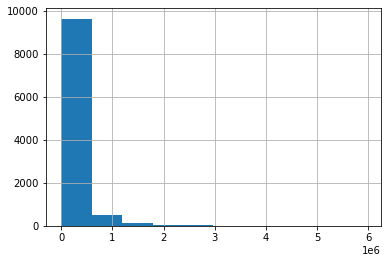

In [21]:
df_SC['line_item_value'].hist()

Nous allons donc appliquer la transformation logarithmique ainsi la transformation racine carrée à cette colonne.

<AxesSubplot:ylabel='Frequency'>

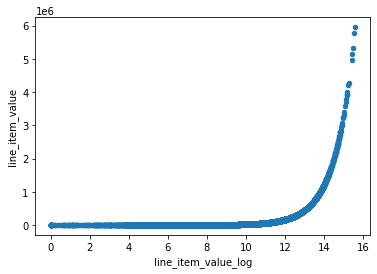

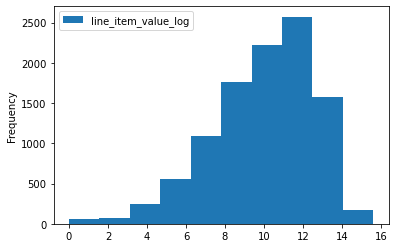

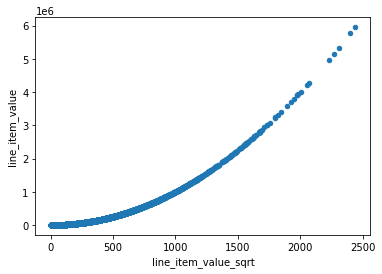

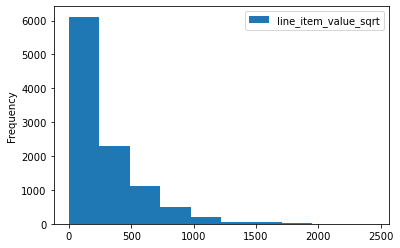

In [22]:
# appliquons la transformation logarithmique
# notez que np.log calcule le logarithme naturel (c.-à-d., ln(x))
# on utilise +1 pour éviter de se retrouver avec ln(0) 
df_SC['line_item_value_log'] = np.log(df_SC['line_item_value'] + 1)
# df_SC['line_item_value_log'] = [math.log(x+1) for x in df_SC['line_item_value']]

# appliquons la transformation racine carrée
df_SC['line_item_value_sqrt'] = np.sqrt(df_SC['line_item_value'])
# df_SC['line_item_value_sqrt'] = [math.sqrt(x) for x in df_SC['line_item_value']]

# visualisons les résultats
df_SC[['line_item_value','line_item_value_log']].plot(x='line_item_value_log', y='line_item_value', kind='scatter')
df_SC[['line_item_value_log']].plot(kind='hist')

df_SC[['line_item_value','line_item_value_sqrt']].plot(x='line_item_value_sqrt', y='line_item_value', kind='scatter')
df_SC[['line_item_value_sqrt']].plot(kind='hist')

Il est aussi possible d'appliquer la [fonction `boxcox` de SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) pour automatiser la recherche de la meilleure transformation possible:

<AxesSubplot:ylabel='Frequency'>

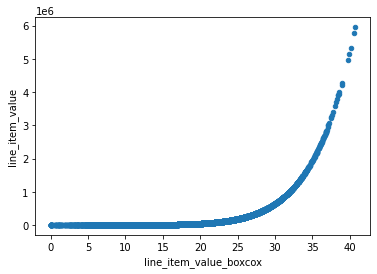

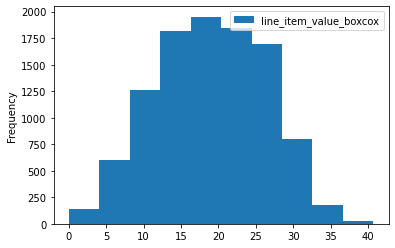

In [23]:
df_SC['line_item_value_boxcox'], lmbda = stats.boxcox(df_SC['line_item_value'] + 1)
df_SC[['line_item_value','line_item_value_boxcox']].plot(x='line_item_value_boxcox', y='line_item_value', kind='scatter')
df_SC[['line_item_value_boxcox']].plot(kind='hist')

On remarque que cette dernière transformation semble nous donner le meilleur résultat!

## Variables binaires
Une variable qualitative devrait généralement être encodé avec des variables binaires. Il existe généralement deux options pour cet encodage:
- Option 1: Définir $k-1$ variables binaires et utiliser la catégorie manquante comme la catégorie de référence. Cette option est à privélégier pour éviter les problèmes de multicolinéarité qui pourrait affecter les analyses statistiques, par exemple, dans une régression linéaire.
- Option 2: Définir $k$ variables binaires. Cette approche est souvent appelée *one-hot encoding*. Cette approche est plutôt utilisée en apprentissage automatique dans les algorithmes qui utilisent de la régularisation. Dans ce cas-ci, lorsque toutes les variables binaires sont zéros, on se retrouve alors avec une valeur manquante.

Transformons notre variable qualitative `shipment_mode` avec ces deux options.

Premièrement, regardons les différentes valeurs possibles dans cette colonne.

In [24]:
df_SC['shipment_mode'].unique()

array(['Air', 'missing', 'Truck', 'Air Charter', 'Ocean'], dtype=object)

Créons maintenant 4 variables binaires avec les noms `'Air Charter'`, `'Ocean'`, `'Truck'` et `'missing'`, et utilisons `'Air'`  comme notre catégorie de référence. Nous pouvons faire cela en utilisant la fonction `pd.get_dummies()` et le paramètre `drop_first=True`. Pour plus d'information, vous pouvez consulter [cette page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

In [25]:
df_dummies = pd.get_dummies(df_SC['shipment_mode'], drop_first=True)
df_dummies.head()

,Air Charter,Ocean,Truck,missing
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


Pour le *one-hot encoding*, nous procédons plutôt de la sorte:

In [26]:
df_onehot = pd.get_dummies(df_SC['shipment_mode'])
df_onehot.head()

,Air,Air Charter,Ocean,Truck,missing
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


Si nous voulons ajouter ces colonnes au DataFrame, nous pouvons alors utiliser la fonction `pd.concat()`. Par exemple, pour ajouter le *one-hot encoding*, nous procédons de la façon suivante:

In [27]:
df_SC = pd.concat([df_SC, df_onehot], axis=1) 
df_SC[df_onehot.columns].describe()

,Air,Air Charter,Ocean,Truck,missing
count,10324.000000,10324.000000,10324.000000,10324.000000,10324.00000
mean,0.592115,0.062960,0.035936,0.274119,0.03487
std,0.491465,0.242903,0.186139,0.446091,0.18346
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,0.000000,0.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


## Discrétisation de variables numériques
Dans certains cas, des variables catégoriques (c.-à-d., qualitatives) peuvent être préférables à des variables numériques. Nous devons alors répartir les variables numériques dans des boîtes.

À titre d'exemple, transformons notre variable initiale `weight_kilograms` en une variable qualitative avec les valeurs `'light'` (si le poids est inférieur ou égal à 100 kg), `'medium'` (si le poids est compris dans l'intervalle [100 kg, 500 kg]), `'heavy'` (si le poids est compris dans l'intervalle [500 kg, 1000 kg]) et `'super-heavy'` (si le poids est > 1000 kg). 

Nous pouvons implémenter cette transformation avec la fonction `pd.cut()`, qui aide à segmenter les données dans des boîtes. Vous pouvez référer à [cette page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) pour plus d'information.

In [28]:
bins = [0, 100., 500., 1000., float('inf')]             # les catégories
names = ['light', 'medium', 'heavy', 'super-heavy']      # les noms des catégories
df_SC['weight_category'] = pd.cut(df_SC['weight_kilograms'], 
                                  bins, 
                                  labels=names, 
                                  include_lowest=True)
df_SC.loc[:10, ['weight_kilograms','weight_category']]

,weight_kilograms,weight_category
0,13.0,light
1,358.0,medium
2,171.0,medium
3,1855.0,super-heavy
4,7590.0,super-heavy
5,504.0,heavy
6,328.0,medium
7,1478.0,super-heavy
8,NaN,NaN
9,643.0,heavy


# Sauvegarde des données

Finalement, après avoir terminé le prétraitement des données, il peut être nécessaire de sauvegarder ces données pour être en mesure de les réutiliser ailleurs. Ceci peut être fait facilement de la sorte:

In [29]:
file = "transformed_df.csv"
df_SC.to_csv(file)

Dans le cas de Google Colab, il faut aussi faire l'étape suivante additionnelle pour télécharger ce fichier.

In [ ]:
from google.colab import files
files.download(file)